In [1]:

# get processed data

import os
import pandas as pd

file_path = "../data/"

data = pd.read_csv(file_path+"train.csv")


# Convert to list

df=data["news_title"]

docs = [str(i) for i in df.values]


import bpemb
from bpemb import BPEmb
import numpy as np

# Load BPEmb model for Tamil

model = BPEmb(lang="ta", dim=300, vs=200000)

# Generate embeddings for news_title column

embeds = []
for title in docs:
    embed = model.embed(title)
    embeds.append(np.mean(embed, axis=0))

embeds = np.array(embeds)



# Tokenize docs trivially (split on spaces)

from indicnlp.tokenize import sentence_tokenize, indic_tokenize

def tokenize_ta(text,return_tensors="pt",*args,**kwargs):
    return indic_tokenize.trivial_tokenize(text)


# Common list of stopwords

stopwords=['அங்கு',
 'அங்கே',
 'அடுத்த',
 'அதனால்',
 'அதன்',
 'அதற்கு',
 'அதிக',
 'அதில்',
 'அது',
 'அதே',
 'அதை',
 'அந்த',
 'அந்தக்',
 'அந்தப்',
 'அன்று',
 'அல்லது',
 'அவன்',
 'அவரது',
 'அவர்',
 'அவர்கள்',
 'அவள்',
 'அவை',
 'ஆகிய',
 'ஆகியோர்',
 'ஆகும்',
 'இங்கு',
 'இங்கே',
 'இடத்தில்',
 'இடம்',
 'இதனால்',
 'இதனை',
 'இதன்',
 'இதற்கு',
 'இதில்',
 'இது',
 'இதை',
 'இந்த',
 'இந்தக்',
 'இந்தத்',
 'இந்தப்',
 'இன்னும்',
 'இப்போது',
 'இரு',
 'இருக்கும்',
 'இருந்த',
 'இருந்தது',
 'இருந்து',
 'இவர்',
 'இவை',
 'உன்',
 'உள்ள',
 'உள்ளது',
 'உள்ளன',
 'எந்த',
 'என',
 'எனக்',
 'எனக்கு',
 'எனப்படும்',
 'எனவும்',
 'எனவே',
 'எனினும்',
 'எனும்',
 'என்',
 'என்ன',
 'என்னும்',
 'என்பது',
 'என்பதை',
 'என்ற',
 'என்று',
 'என்றும்',
 'எல்லாம்',
 'ஏன்',
 'ஒரு',
 'ஒரே',
 'ஓர்',
 'கொண்ட',
 'கொண்டு',
 'கொள்ள',
 'சற்று',
 'சிறு',
 'சில',
 'சேர்ந்த',
 'தனது',
 'தன்',
 'தவிர',
 'தான்',
 'நான்',
 'நாம்',
 'நீ',
 'பற்றி',
 'பற்றிய',
 'பல',
 'பலரும்',
 'பல்வேறு',
 'பின்',
 'பின்னர்',
 'பிற',
 'பிறகு',
 'பெரும்',
 'பேர்',
 'போது',
 'போன்ற',
 'போல',
 'போல்',
 'மட்டுமே',
 'மட்டும்',
 'மற்ற',
 'மற்றும்',
 'மிக',
 'மிகவும்',
 'மீது',
 'முதல்',
 'முறை',
 'மேலும்',
 'மேல்',
 'யார்',
 'வந்த',
 'வந்து',
 'வரும்',
 'வரை',
 'வரையில்',
 'விட',
 'விட்டு',
 'வேண்டும்',
 'வேறு']

from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts for topic representation - TOKENIZATION STEP

vectorizer_model = CountVectorizer(
    stop_words=stopwords,analyzer='word',
    tokenizer=tokenize_ta
)


# Create a BERTopic model

from bertopic import BERTopic

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    verbose=True,
    calculate_probabilities=False,
    embedding_model=model,
    
)

# Fit the model on the documents

embeds_np = embeds

topics = topic_model.fit_transform(docs,embeds_np)


/Users/samyuktha/opt/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-04-24 17:37:05,688 - BERTopic - Reduced dimensionality
2023-04-24 17:37:05,919 - BERTopic - Clustered reduced embeddings


In [2]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,4677,-1_கைது_போலீஸ்_கொலை_பெண்
1,0,226,0_நடிகை_நடிகர்_இயக்குனர்_நடிக்க
2,1,189,1_தேர்தல்_ஆணையம்_வாக்கு_அதிகாரி
3,2,174,2_ரயில்_பஸ்_நிலையத்தில்_ரயில்கள்
4,3,169,3_அரசு_மத்திய_நிதி_உதவி
...,...,...,...
143,142,10,142_தள்ளிவைப்பு_தள்ளிவைக்க_மனு_தேர்வுகளை
144,143,10,143_ஹீரோ_காதலுக்கு_இயக்குனர்_நடிகை
145,144,10,144_டிப்ஸ்_போரூரில்_எம்ஜிஆரையே_பிடிக்காத
146,145,10,145_வயது_கதாசிரியர்_அழகியை_பாட்டியாகி


In [3]:
new_topics = topic_model.reduce_outliers(
    docs, topic_model.topics_, strategy="c-tf-idf")
topic_model.update_topics(
    docs, topics=new_topics, vectorizer_model=vectorizer_model)


In [4]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,86,-1_எகிறும்_வார்ன்_மாதத்துக்கு_மியாவ்
1,0,272,0_நடிகை_நடிகர்_இயக்குனர்_நடிக்க
2,1,253,1_தேர்தல்_ஆணையம்_வாக்கு_கமிஷன்
3,2,215,2_ரயில்_பஸ்_ரயில்கள்_நிலையத்தில்
4,3,225,3_அரசு_மத்திய_நிதி_பிரணாப்
...,...,...,...
143,142,29,142_தள்ளிவைப்பு_தேர்தலை_தள்ளிவைக்க_செயலக
144,143,20,143_காதலுக்கு_ஹீரோ_ஹீரோவை_நீக்கம்
145,144,27,144_டிப்ஸ்_அசத்தல்_எப்படி_ஷூவை
146,145,30,145_வயது_மரணம்_பாட்டி_காதலிக்கிறார்


In [5]:
df_with_topics = pd.DataFrame({'text':docs,'topic':topics[0]})

df_with_topics

,text,topic
0,தூக்கில் தொங்கும் சேவல்கள் திருடர்களை காவு வாங...,-1
1,பவுர்ணமி ஜாமத்தில் மாயமான கர்ப்பிணி,45
2,மச்சுபிச்சு மலை ரகசியம்,4
3,ரத்த பலி வாங்கும் விபரீத ஆவி,70
4,உலகப் பேரழகியின் மர்ம மரணம்,-1
...,...,...
9995,காஞ்சியில் சமச்சீர் கல்வி வெற்றி விழா முகஸ்டால...,78
9996,தமிழகம் புதுச்சேரியில் இடி மின்னலுடன் மழை பெய்...,60
9997,புதிய தலைமை செயலக கட்டிடத்தில் சிறப்பு மருத்து...,-1
9998,கூடங்குளத்தில் உளவுப்படை போலீஸ் தீவிர கண்காணிப்பு,-1


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
# Define a function to generate recommendations using the same topic cluster method
def same_topic_recommend(article, df, embeds_np):
    # find all documents with same topic as sample article and get their embeddings from embeds_np
    same_topic_docs = df[df['topic'] == article['topic']]
    same_topic_docs_embeddings = embeds_np[same_topic_docs.index]

    article_embedding = embeds_np[article.name].reshape(1, -1)

    cosine_similarities = cosine_similarity(article_embedding, same_topic_docs_embeddings)
    
    return cosine_similarities.mean()

In [8]:
# Define a function to generate recommendations using the entire dataset method
def all_articles_recommend(article, df, embeds_np):
    article_embedding = embeds_np[article.name].reshape(1, -1)
    cosine_similarities = cosine_similarity(article_embedding, embeds_np)
    return cosine_similarities.mean()

In [9]:
from datetime import datetime


def evaluate_recommendations(df, embeds_np):
    # initialize list to store cosine similarity scores
    cos_sim_scores = []


    # loop through each article in the set
    for _, article in df.iterrows():
        # get the recommended articles using both methods
        start_time = datetime.now()
        method1_cos_sim_scores = same_topic_recommend(article, df, embeds_np)
        time_taken1 = datetime.now() - start_time
        time_taken1= time_taken1.total_seconds()


        start_time = datetime.now()
        method2_cos_sim_scores = all_articles_recommend(article, df, embeds_np)
        time_taken2 = datetime.now() - start_time
        time_taken2= time_taken2.total_seconds()

        # append the cosine similarity scores to the list
        cos_sim_scores.append([method1_cos_sim_scores, time_taken1,method2_cos_sim_scores,time_taken2])
    # convert the list to a pandas DataFrame
    cos_sim_scores_df = pd.DataFrame(cos_sim_scores, columns=['Same Topic','Time Taken for Same Topic method','All articles','Time Taken for All articles method'])

    # return the DataFrame
    return cos_sim_scores_df

In [10]:
scores_df=evaluate_recommendations(df_with_topics,embeds_np)
scores_df

,Same Topic,Time Taken for Same Topic method,All articles,Time Taken for All articles method
0,0.096102,0.004516,0.088594,0.003876
1,0.305278,0.000407,0.119238,0.004006
2,0.331955,0.001301,0.184620,0.006251
3,0.407787,0.000465,0.121874,0.002655
4,0.203024,0.004046,0.195803,0.003906
...,...,...,...,...
9995,0.604190,0.000626,0.239446,0.002741
9996,0.492529,0.000302,0.140468,0.002619
9997,0.259537,0.003213,0.261916,0.002745
9998,0.208011,0.002799,0.201645,0.002730


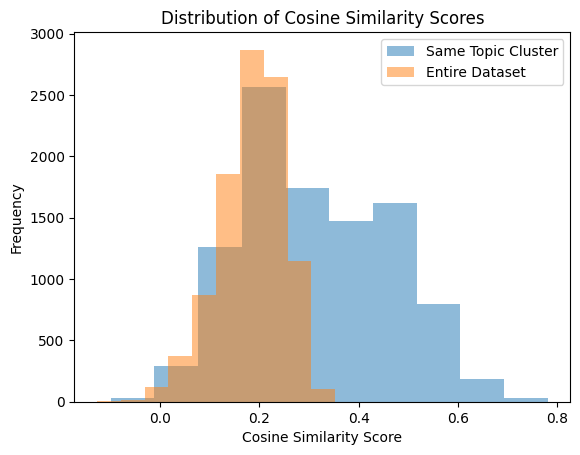

Mean cosine similarity (Same Topic Cluster): 0.3128966
Average time taken for Same Topic Cluster method: 0.0026630523000000005
Mean cosine similarity (Entire Dataset): 0.18427074
Average time taken for Entire Dataset method: 0.0045469169


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean cosine similarity for both methods

cosine_similarities_topic = scores_df['Same Topic']
cosine_similarities_all = scores_df['All articles']

mean_cosine_similarities_topic = np.mean(cosine_similarities_topic)
mean_cosine_similarities_all = np.mean(cosine_similarities_all)

# Plot distribution of cosine similarity scores
fig, ax = plt.subplots()
ax.hist(cosine_similarities_topic, alpha=0.5, label='Same Topic Cluster')
ax.hist(cosine_similarities_all, alpha=0.5, label='Entire Dataset')
ax.legend()
ax.set_xlabel('Cosine Similarity Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Cosine Similarity Scores')
plt.show()

# Print mean cosine similarity scores
print('Mean cosine similarity (Same Topic Cluster):', mean_cosine_similarities_topic)
print('Average time taken for Same Topic Cluster method:', scores_df['Time Taken for Same Topic method'].mean())
print('Mean cosine similarity (Entire Dataset):', mean_cosine_similarities_all)
print('Average time taken for Entire Dataset method:', scores_df['Time Taken for All articles method'].mean())